<a href="https://colab.research.google.com/github/jiseon0516/pdm19/blob/main/py-tensorflow/pdm19_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 추가 내용

## transfer learning (TL)이란

- 전이학습은 247*247*3 크기의 데이터가 14000여 개가 존재하고 1000개의 클래스로 구성되어 있는 imagenet dataset을 사용한다.
- 전이학습에서 훈련시키는데 사용되는 데이터는 일부는 원래 데이터로, 나머지는 새로운 데이터이다.
- 전이학습의 모델은 ResNet50, VGG16, VGG19, ConvNet 등이 있다.
- VGG16은 CNN단계가 13개, FCN단계가 3개로 구성되어 있다.
- ConvNet은 convolutinal layers(convnet) +(flatten=maxpooling)+ endse layers(fcn) 과정을 거친다. 즉, convolution layer를 이용해 만들어진 특징들은(특징추출) 내가 구성한 fcn으로 훈련한다. 
- 전이학습은 DL, DL with Daug 등으로 훈련된 것보다 더 높은 정확도를 띤다.

## cifar10에 대한 TL 결과 요약

**1.   10%의 cifar10 데이터 추출하기**
- cifar10 데이터 load를 해서 얻은 (trainX, trainy) 데이터에서 train_test_split 함수를 이용해 10%의 cifar10 데이터를 추출한다. => 결과: Xtest, ytest 
- Xtest, ytest에서 train_test_split 함수를 이용해 10% cifar10 데이터를 검증할 테스트 데이터를 10% 더 추출한다. => 결과: Xtest_test, ytest_test
- 즉, 훈련하는데 사용되는 데이터는 Xtrain_train, ytrain_train이고 검증에 사용되는 데이터는 Xtest_test, ytest_test이다.
- 정리: Xtest, ytest에서 훈련데이터(90%): Xtrain_train, ytrain_train이고 검증데이터(10%): Xtest_test, ytest_test이다.
- 데이터 전처리, 데이터 보간 사용


**2.   TL_Base: MobileNetV2 사용**
- MobileNetV2를 사용해 Sequential model을 생성함
- 내가 설계한 conv + flatten + fcn 4층 구조를 만들었음
- callback 함수 설정 후 Xtrain_train, ytrain_train 데이터로 학습시키고 Xtest_test, ytest_test 데이터로 검증함 
- loss, accuracy 그래프를 그림


**3.   Fine Tuning 사용**
- 2번에 실행했던 것에 이어 계속 학습시킴
- accuracy, loss 그래프 그리기
- Best model 저장
- Confusion Matrix 그리기

# 10% cifar10 데이터 만들기

### data load

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

tf.random.set_seed(0)

print(tf.__version__)

2.7.0


In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train_nine, X_result, y_train_nine, y_result = train_test_split(trainX, trainy, random_state=0, test_size=0.1, stratify=trainy)

In [ ]:
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))



# Normalization
# trainX, testX = trainX/255.0, testX/255.0 # 정규화
# X_result = X_result/255.0

# print("X_train={0}".format(X_train.shape))
# print("y_train={0}".format(y_train.shape)) 
# print("X_test={0}".format(X_test.shape))
# print("y_test={0}".format(y_test.shape))
# print("X_result={0}".format(X_result.shape))
# print("y_result={0}".format(y_result.shape))
#training의 10% split -> numpy 코드 이용(사이킷런)


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [ ]:
from sklearn.model_selection import train_test_split
# 10% cifar10 데이터
Xtrain, Xtest, ytrain, ytest = train_test_split(trainX, trainy, random_state=42, test_size=0.1, stratify=trainy) # shuffle=1.0,
# 10% cifar10 데이터에 대한 테스트 데이터
Xtrain_train, Xtest_test, ytrain_train, ytest_test = train_test_split(Xtest, ytest, random_state=42, test_size=0.1, stratify=ytest)


print('10_cifar10 data: X=%s, y=%s' % (Xtest.shape, ytest.shape))
print('10_cifar10 test data: X=%s, y=%s' %(Xtest_test.shape, ytest_test.shape))

10_cifar10 data: X=(5000, 32, 32, 3), y=(5000, 1)
10_cifar10 test data: X=(500, 32, 32, 3), y=(500, 1)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(trainy, 10)
y_test = to_categorical(testy, 10)
y_test0 = to_categorical(ytest, 10)
y_train_train = to_categorical(ytrain_train, 10)
y_test_test = to_categorical(ytest_test, 10)
y_train.shape,y_test.shape,y_test0.shape, y_test_test.shape

((50000, 10), (10000, 10), (5000, 10), (500, 10))

In [ ]:
trainy.shape, y_train.shape

((50000, 1), (50000, 10))

### Display images in CIFAR-10

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

43406


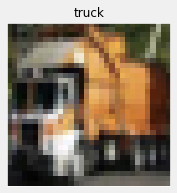

In [ ]:
idx = np.random.randint(0, trainX.shape[0])
print(idx)
image = trainX[idx]
plt.figure(figsize=(3,3))
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[trainy[idx][0]])
plt.xticks([])
plt.yticks([])
plt.show()

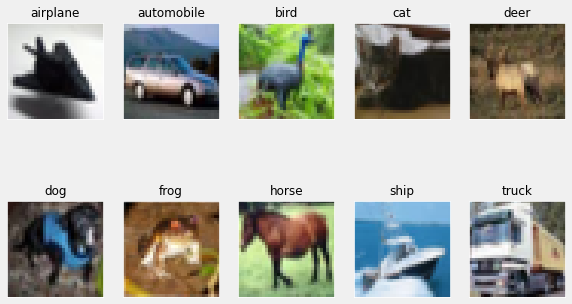

In [ ]:
fig = plt.figure(figsize=(10,6))
num0_9 = np.unique(trainy, return_index=True)[1]
images = trainX[num0_9]
for i in range(10):
    plt.subplot(2, 5, i+1)
    # num0_9 = X_train0[y_train0 == i]
    
    # print(num0_9.shape)
    # plt.imshow(num0_9[0]) 
    plt.imshow(images[i])
    plt.title(class_names[i])
    plt.xticks([])
    plt.yticks([])

716


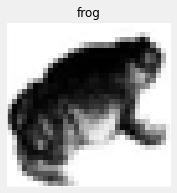

In [ ]:
idx = np.random.randint(0, Xtest.shape[0])
print(idx)
image = Xtest[idx]
plt.figure(figsize=(3,3))
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[int(ytest[idx][0])])
plt.xticks([])
plt.yticks([])
plt.show()

161


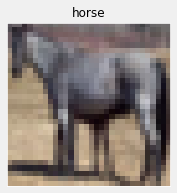

In [ ]:
idx = np.random.randint(0, Xtest_test.shape[0])
print(idx)
image = Xtest_test[idx]
plt.figure(figsize=(3,3))
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[int(ytest_test[idx][0])])
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
import os
# Matplotlib config
# plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='000000')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title): #test data 중 임의로 10개 데이터 선택, digits: 인덱스, 예측(predictions)과 실제 정답 값(labels), title

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    true_index = n_labels[i]
    # Set x-label color: green if prediction correct and red if prediction incorrect
    plt.xlabel(class_names[class_index])
    xlabel_color = "green" if n_predictions[i] == n_labels[i] else "red"
    ax.xaxis.label.set_color(xlabel_color) 
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

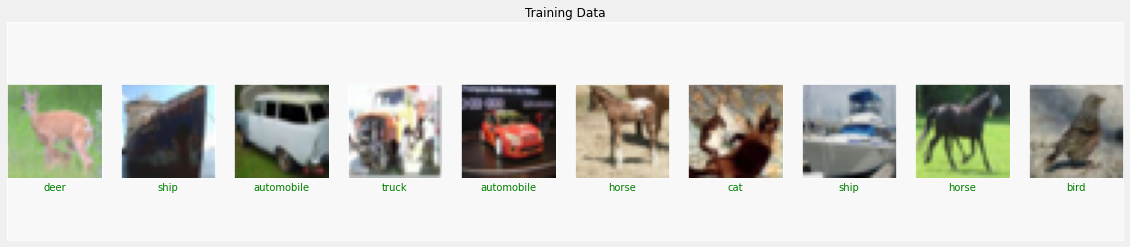

In [ ]:
display_images(trainX, trainy, trainy, "Training Data")

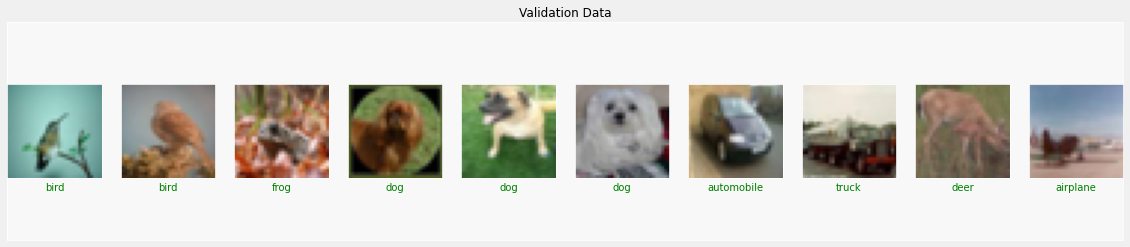

In [ ]:
display_images(testX, testy, testy, "Validation Data" )

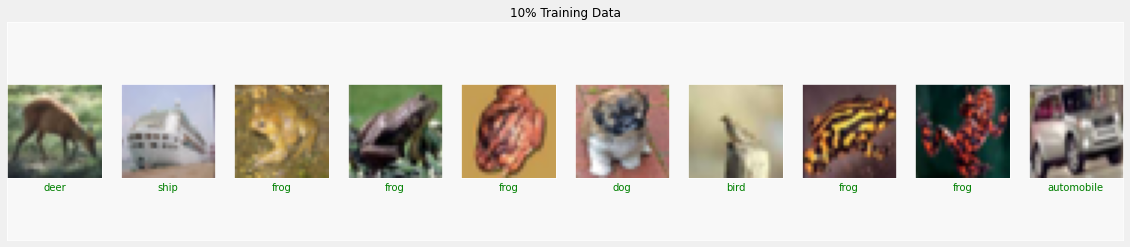

In [ ]:
display_images(Xtest, ytest, ytest, "10% Training Data" )

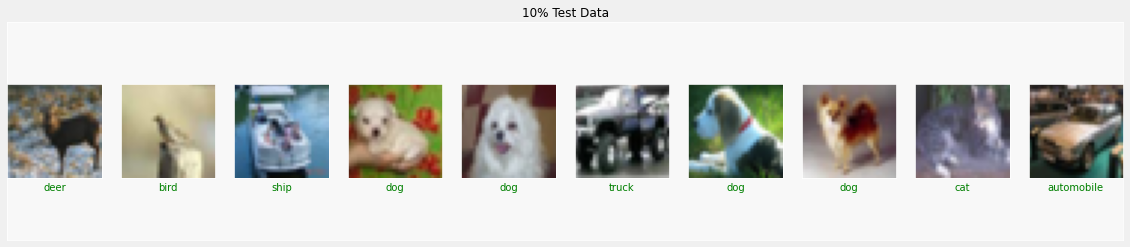

In [ ]:
display_images(Xtest_test, ytest_test, ytest_test, "10% Test Data" )

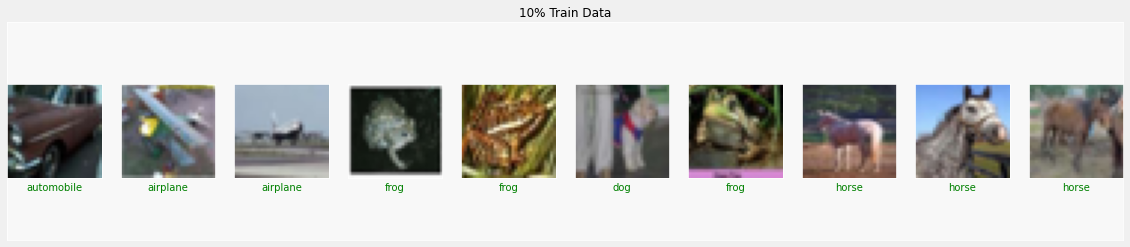

In [ ]:
display_images(Xtrain_train, ytrain_train, ytrain_train, "10% Train Data" )

# Preprocess the dataset



In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


In [ ]:
def preprocess_image_input(input_images): #이미지 픽셀 값 정수 -> 실수, preprocess_input함수로 바꿔줌(정규화)
  input_images = input_images.astype('float32')
  output_ims = preprocess_input(input_images)
  return output_ims

In [ ]:
#전처리 된 데이터
x_train = preprocess_image_input(trainX)
x_test = preprocess_image_input(testX)
x_test0 = preprocess_image_input(Xtest)
x_train_train = preprocess_image_input(Xtrain_train)
x_test_test = preprocess_image_input(Xtest_test)

In [ ]:
x_train.shape,len(x_train),x_train[4].shape

((50000, 32, 32, 3), 50000, (32, 32, 3))

In [ ]:
x_test.shape,len(x_test),x_test[4].shape

((10000, 32, 32, 3), 10000, (32, 32, 3))

In [ ]:
x_test0.shape,len(x_test0),x_test0[4].shape

((5000, 32, 32, 3), 5000, (32, 32, 3))

In [ ]:
x_test_test.shape,len(x_test_test),x_test_test[4].shape

((500, 32, 32, 3), 500, (32, 32, 3))

In [ ]:
x_train_train.shape, len(x_train_train), x_train_train[4].shape

((4500, 32, 32, 3), 4500, (32, 32, 3))

In [ ]:
y_train=trainy
y_test=testy
y_test0 = ytest
y_train_train = ytrain_train
y_test_test = ytest_test
y_train.shape,y_test.shape,y_test0.shape, y_train_train.shape, y_test_test.shape

((50000, 1), (10000, 1), (5000, 1), (4500, 1), (500, 1))

# Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.3
    #zoom_range=0.3
    )
datagen.fit(Xtest/255.0)

(50, 32, 32, 3) (50, 1)


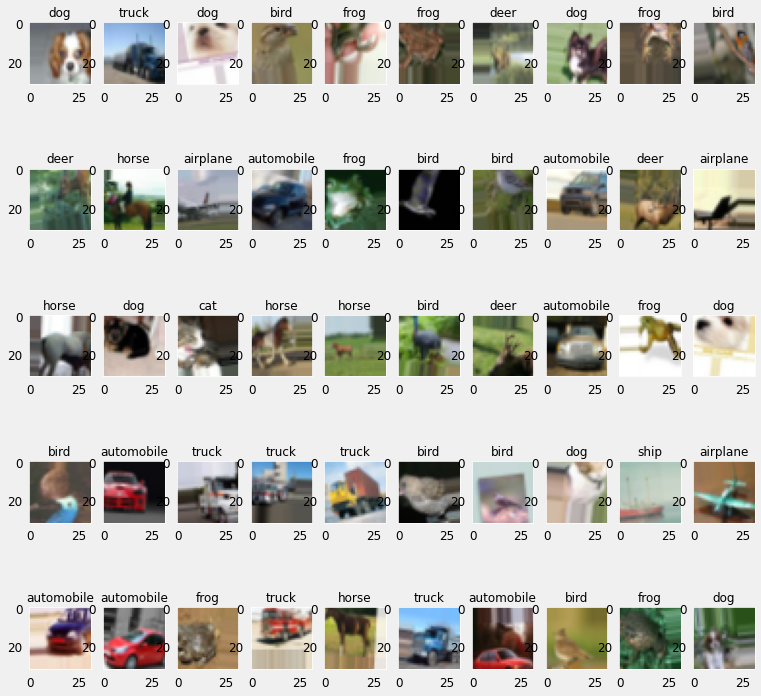

In [ ]:
BATCH_SIZE = 50
for X_batch, y_batch in datagen.flow(Xtrain_train/255.0, ytrain_train, batch_size=BATCH_SIZE):
    print(X_batch.shape, y_batch.shape)
    # create a grid of 5x10 images
    plt.figure(figsize=(13,13))
    for i in range(BATCH_SIZE):
        plt.subplot(5,10,i+1)
        plt.imshow(X_batch[i]) #, cmap=plt.get_cmap('gray'))
        plt.title(class_names[int(y_batch[i])])
        # show the plot
    plt.show()
    break

# Design

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
len(TL_base.layers)

154

In [ ]:
print([x.name for x in TL_base.layers],end=' ')

['input_10', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand', 'block_5_expand_BN', 'block_5_expand

In [ ]:
TL_base.layers[81].name, TL_base.layers[107].name

('block_9_expand', 'block_12_expand')

In [ ]:
TL_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
TL_base.layers[-1].get_config()

{'dtype': 'float32',
 'max_value': array(6., dtype=float32),
 'name': 'out_relu',
 'negative_slope': array(0., dtype=float32),
 'threshold': array(0., dtype=float32),
 'trainable': True}

### Sequential model

In [ ]:
TL_base.trainable = False

In [ ]:
model = models.Sequential()
model.add(keras.Input(shape=(32,32,3))) #image: 224*224*3
model.add(layers.UpSampling2D((7,7)))  # 32*7 = 224 #가로, 세로 각각 7배씩 => 크기 확대
model.add(TL_base) #input을 TL_base에 넣어줌, frozen - convolution단계는 고정(기존 파라미터 이용)
model.add(layers.GlobalAveragePooling2D()) # (7,7,2048) => (2048,) #1280개짜리 벡터 만들어짐
model.add(layers.Flatten()) #fcn 설계
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu')) #fcn1
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu')) #fcn2
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu')) #fcn3
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax')) #output layer

model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_5 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_5 (Flatten)         (None, 1280)              0         
                                                                 
 batch_normalization_20 (Bat  (None, 1280)             5120      
 chNormalization)                                     

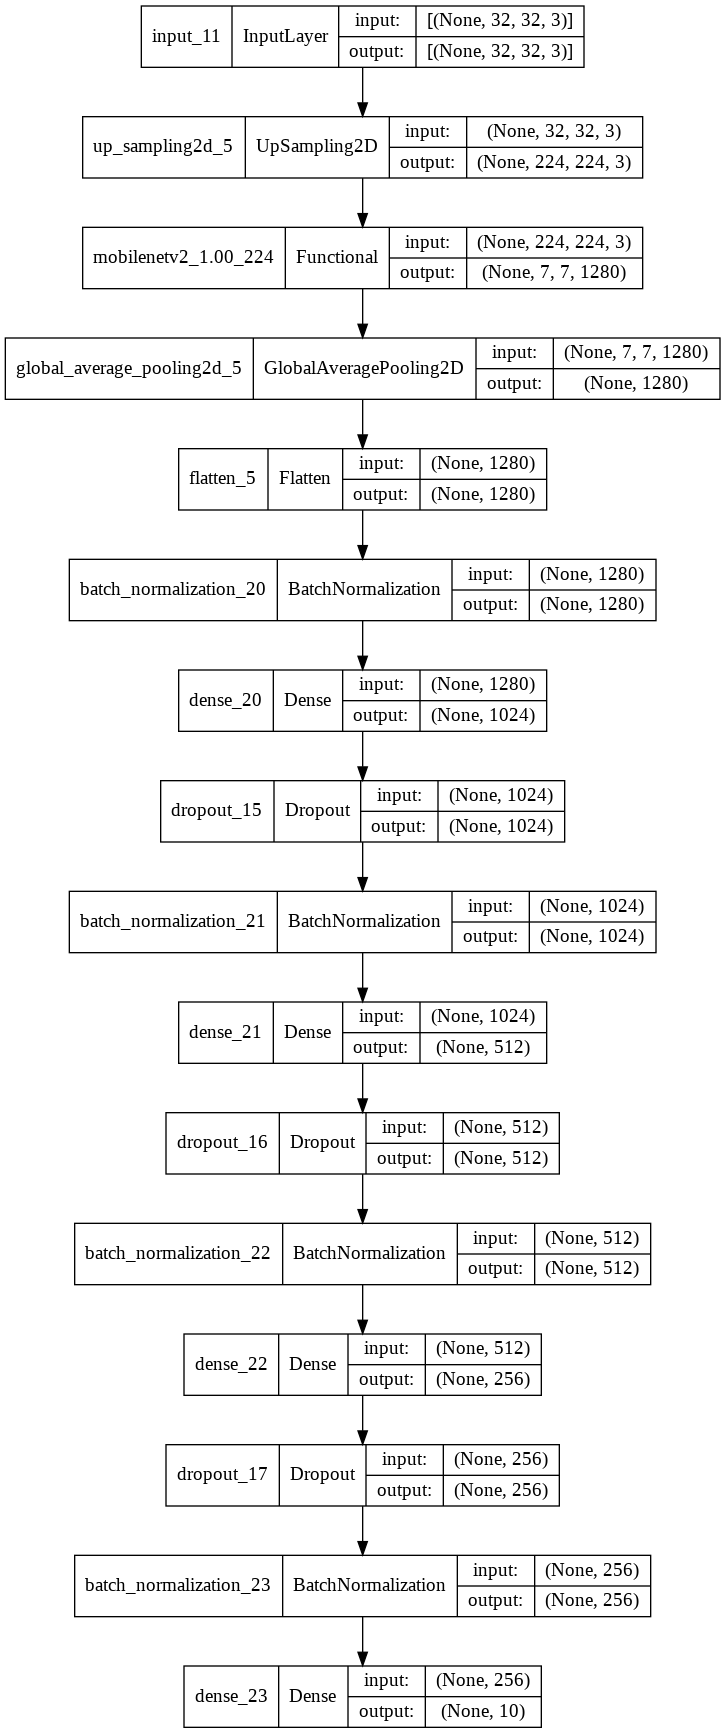

In [ ]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_S.png')

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/tf2_practice.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [ ]:
%%time
history = model.fit(Xtrain_train/255.0, ytrain_train, #만장
                    epochs=100, batch_size=50, 
                    validation_data=(Xtest_test/255.0, ytest_test), #천장
                    callbacks=[mc_callback,es_callback])

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 2.6703 - accuracy: 0.1627

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


90/90 [==============================] - 151s 2s/step - loss: 2.6703 - accuracy: 0.1627 - val_loss: 1.9422 - val_accuracy: 0.3720
Epoch 2/100
90/90 [==============================] - 151s 2s/step - loss: 2.2644 - accuracy: 0.2420 - val_loss: 1.6773 - val_accuracy: 0.4960
Epoch 3/100
90/90 [==============================] - 147s 2s/step - loss: 2.0230 - accuracy: 0.3124 - val_loss: 1.5128 - val_accuracy: 0.5180
Epoch 4/100
90/90 [==============================] - 148s 2s/step - loss: 1.8826 - accuracy: 0.3536 - val_loss: 1.4081 - val_accuracy: 0.5480
Epoch 5/100
90/90 [==============================] - 148s 2s/step - loss: 1.7409 - accuracy: 0.3924 - val_loss: 1.3429 - val_accuracy: 0.5660
Epoch 6/100
90/90 [==============================] - 147s 2s/step - loss: 1.6491 - accuracy: 0.4169 - val_loss: 1.3081 - val_accuracy: 0.5640
Epoch 7/100
90/90 [==============================] - 147s 2s/step - loss: 1.6024 - accuracy: 0.4389 - val_loss: 1.2781 - val_accuracy: 0.5700
Epoch 8/100
90/90 

### Evaluate the Model

In [ ]:
model.evaluate(x_test_test/255.0, y_test_test, batch_size=50)

10/10 [==============================] - 13s 1s/step - loss: 5.7236 - accuracy: 0.1000


[5.723628997802734, 0.10000000149011612]

## loss, accuracy 그래프

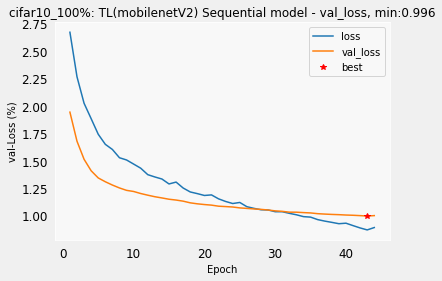

In [ ]:
#훈련데이터와 검증데이터에 대한 loss 시각화
epochs = range(1, len(history.history['loss']) + 1)

loss_list = history.history['loss'] #[100 * i for i in history.history['loss']]
vloss_list = history.history['val_loss'] #[100 * i for i in history.history['val_loss']]

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],3)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

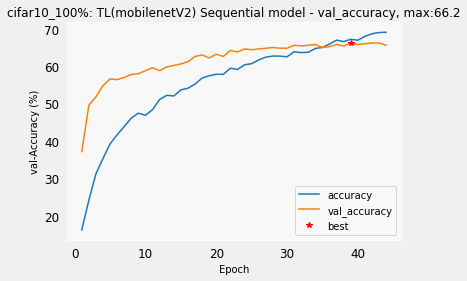

In [ ]:
#훈련데이터와 검증데이터에 대한 accuracy 시각화
epochs = range(1, len(history.history['accuracy']) + 1)

acc_list = [100 * i for i in history.history['accuracy']]
vacc_list = [100 * i for i in history.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],3)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()

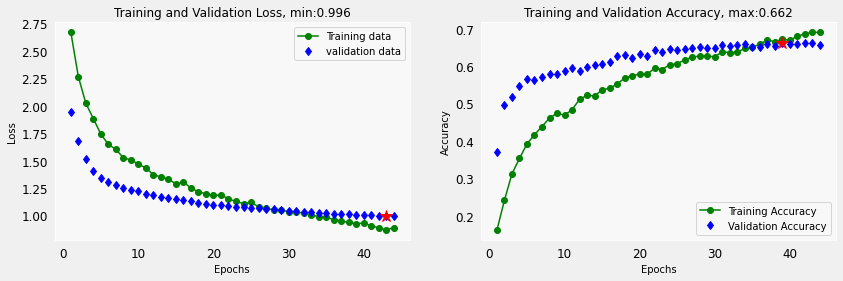

In [ ]:
#loss and accuracy 그래프
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
plt.figure(figsize = (14,4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training data')
plt.plot(epochs, val_loss, 'bd', label='validation data')
plt.plot(np.argmin(np.array(val_loss))+1, val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min:' + str(np.round(val_loss[np.argmin(np.array(val_loss))], 3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) +1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy')
plt.plot(np.argmax(np.array(val_acc))+1, val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max:' + str(np.round(val_acc[np.argmax(np.array(val_acc))], 3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### visualize predictions

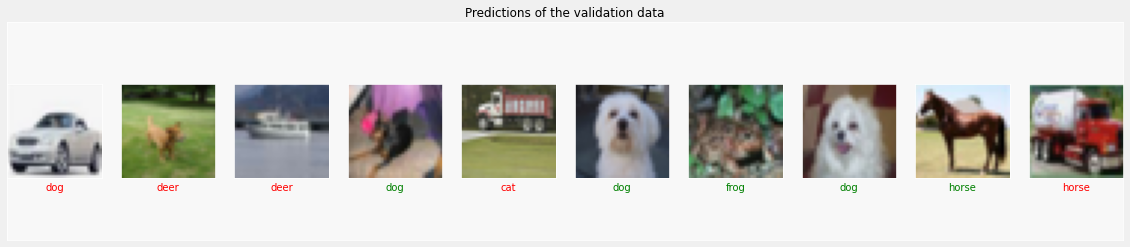

In [ ]:
probabilities = model.predict(x_test_test, batch_size=50)
probabilities = np.argmax(probabilities, axis=1)
display_images(Xtest_test, probabilities, ytest_test, "Predictions of the validation data")

# Fine tuning

In [ ]:
tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(TL_base.layers))

Number of layers in the base model:  154


In [ ]:
fine_tune_at = 107  # 81, 107 for mobilenetV2

# Freeze all the layers before the `fine_tune_at` layer #내가 훈련시키는 위치 설정 기준 
for layer in TL_base.layers[:fine_tune_at]:
  layer.trainable =  False #107 이전 파라미터는 frozen(고정)

In [ ]:
model.compile(optimizer='SGD', #최적화
                loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy - 시간 단축
                metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_5 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_5 (Flatten)         (None, 1280)              0         
                                                                 
 batch_normalization_20 (Bat  (None, 1280)             5120      
 chNormalization)                                     

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_pct100_mobileNetV2S_FT_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

### Train the fine-tuned model

In [ ]:
INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS 

In [ ]:
%%time
history_fine = model.fit(Xtrain_train/255.0, ytrain_train, 
                    epochs=TOTAL_EPOCHS, 
                    initial_epoch=INITIAL_EPOCHS,
                    batch_size=50, 
                    validation_data=(Xtest_test/255.0, ytest_test),
                    callbacks=[mc_callback,es_callback])

Epoch 45/144
90/90 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.9340

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


90/90 [==============================] - 261s 3s/step - loss: 0.2493 - accuracy: 0.9340 - val_loss: 1.6038 - val_accuracy: 0.4880
Epoch 46/144
90/90 [==============================] - 261s 3s/step - loss: 0.1954 - accuracy: 0.9502 - val_loss: 1.4128 - val_accuracy: 0.5480
Epoch 47/144
90/90 [==============================] - 259s 3s/step - loss: 0.1688 - accuracy: 0.9644 - val_loss: 1.4154 - val_accuracy: 0.5980
Epoch 48/144
90/90 [==============================] - 258s 3s/step - loss: 0.1402 - accuracy: 0.9716 - val_loss: 1.2512 - val_accuracy: 0.5880
Epoch 49/144
90/90 [==============================] - 259s 3s/step - loss: 0.1218 - accuracy: 0.9744 - val_loss: 1.3525 - val_accuracy: 0.6020
Epoch 50/144
90/90 [==============================] - 258s 3s/step - loss: 0.1165 - accuracy: 0.9762 - val_loss: 1.2395 - val_accuracy: 0.6320
Epoch 51/144
90/90 [==============================] - 256s 3s/step - loss: 0.0953 - accuracy: 0.9816 - val_loss: 1.1694 - val_accuracy: 0.6480
Epoch 52/144

### Display training curve


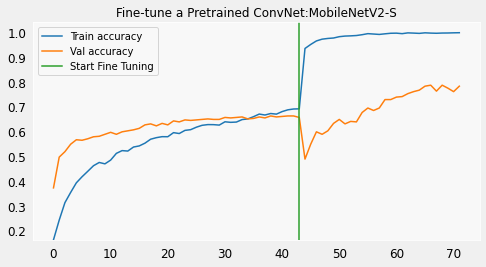

In [ ]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize = (8,4))

plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label = 'Val accuracy')
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(ymin=acc[0]), label='Start Fine Tuning')
plt.title("Fine-tune a Pretrained ConvNet:MobileNetV2-S")
plt.legend(loc='upper left')

plt.show()

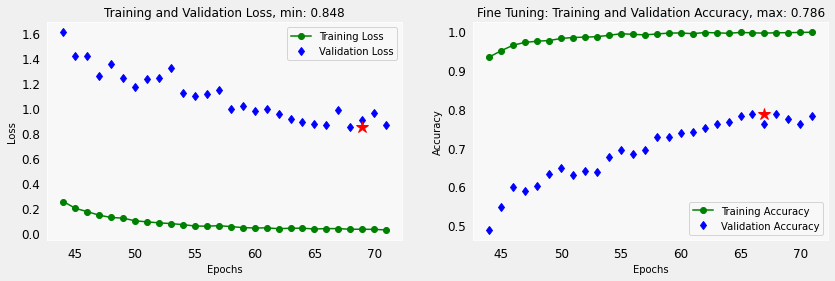

In [ ]:
history_dict = history_fine.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(INITIAL_EPOCHS, INITIAL_EPOCHS+len(loss))

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(INITIAL_EPOCHS + np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy')#, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(INITIAL_EPOCHS + np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Fine Tuning: Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

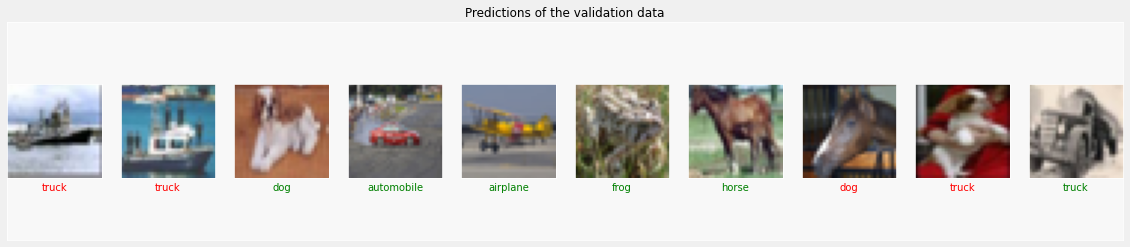

In [ ]:
probabilities = model.predict(x_test_test, batch_size=50)
probabilities = np.argmax(probabilities, axis = 1)

display_images(Xtest_test, probabilities, ytest_test, "Predictions of the validation data")

# Best model
- cifar10_pct100_mobileNetV2S_FT_SGD_best_weights.067-0.7860.hdf5

In [ ]:
from keras.models import load_model

model_best = load_model('model/cifar10_pct100_mobileNetV2S_FT_SGD_best_weights.067-0.7860.hdf5')
model_best.evaluate(x_test0, y_test0, batch_size=BATCH_SIZE)

100/100 [==============================] - 181s 1s/step - loss: 0.4688 - accuracy: 0.8548


[0.4687971770763397, 0.8547999858856201]

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model_best.predict(x_test0)
predictions0 = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test0, predictions0)

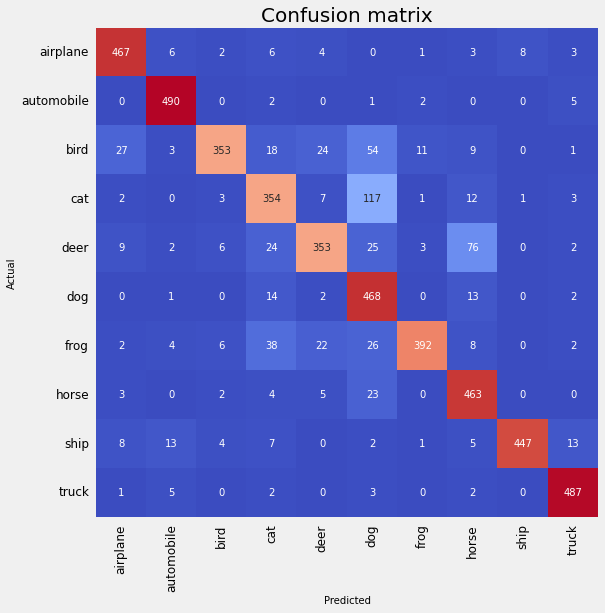

In [ ]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()